Call Option Price: 142.7966130137139
Put Option Price: 131.7988932599946


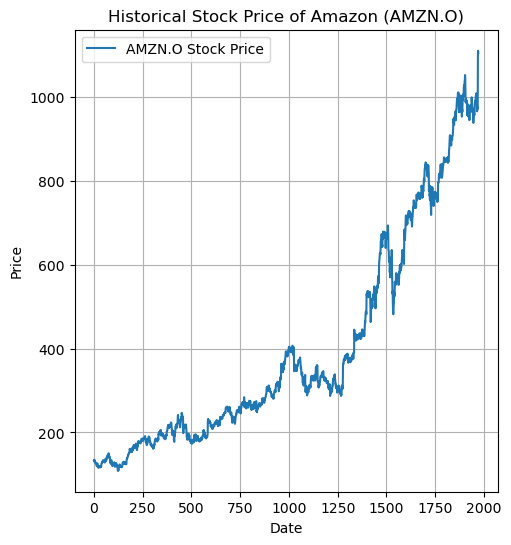

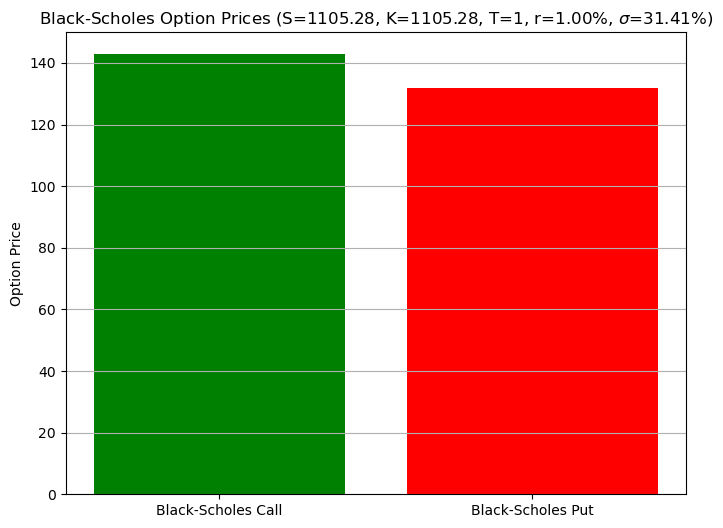

In [87]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sympy import symbols
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load data from CSV file (replace 'your_data.csv' with your file)
data = pd.read_csv('tr_eikon_eod_data.csv')


# 1. Black-Scholes Model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Calculates European option price using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    return price

S = data['AMZN.O'].iloc[-1]  # Current stock price (last closing price)
K = S  # Strike price (at-the-money option)
T = 1  # Time to maturity (1 year)
r = 0.01  # Risk-free interest rate (1%)
sigma = np.std(data['AMZN.O'].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility


call_prices_bs = black_scholes(S, K, T, r, sigma, option_type='call')
put_prices_bs = black_scholes(S, K, T, r, sigma, option_type='put')

# Print the calculated option prices
print(f"Call Option Price: {call_prices_bs}")
print(f"Put Option Price: {put_prices_bs}")


# --- Visualization ---

# 1. Historical Stock Price and Volatility
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data.index, data['AMZN.O'], label='AMZN.O Stock Price')
plt.title('Historical Stock Price of Amazon (AMZN.O)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()


# 2. Black-Scholes Option Prices
labels = ['Black-Scholes Call', 'Black-Scholes Put']
prices = [call_prices_bs, put_prices_bs]

plt.figure(figsize=(8, 6))
plt.bar(labels, prices, color=['green', 'red'])
plt.ylabel('Option Price')
plt.title(f'Black-Scholes Option Prices (S={S:.2f}, K={K:.2f}, T={T}, r={r:.2%}, $\\sigma$={sigma:.2%})')
plt.grid(axis='y')
plt.show()


In [134]:

# 2. Binomial Tree Model (CRR Method)
def binomial_tree(S, K, T, r, sigma, n=100, option_type='call'):



    """Calculates European option price using the Binomial Tree (CRR) model."""
    n = 100 #number of time steps 
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

# Initialize price tree
    prices = np.zeros((n + 1, n + 1))
    prices[0, 0] = S

# Build price tree
    for i in range(1, n + 1):
        prices[i, 0] = prices[i - 1, 0] * d
        for j in range(1, i + 1):
            prices[i, j] = prices[i - 1, j - 1] * u

# Initialize option value tree at expiration
    option_values = np.zeros((n + 1, n + 1))
    if option_type == 'call':
        option_values[n, :] = np.maximum(0, prices[n, :] - K)
    elif option_type == 'put':
        option_values[n, :] = np.maximum(0, K - prices[n, :])
    else:
        raise ValueError("Option type must be 'call' or 'put'")

# Backward induction to find option price at t=0
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_values[i, j] = np.exp(-r * dt) * (p * option_values[i + 1, j + 1] + (1 - p) * option_values[i + 1, j])
    
    return option_values[0, 0]

        
# Load data from CSV file (replace 'your_data.csv' with your file)
    data = pd.read_csv('tr_eikon_eod_data.csv')
    S = data['AMZN.O'].iloc[-1]  # Current stock price (last closing price)
    K = S  # Strike price (at-the-money option)
    T = 1  # Time to maturity (1 year)
    r = 0.01  # Risk-free interest rate (1%)
    sigma = np.std(data['AMZN.O'].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility


# Calculate call and put prices and the trees

call_prices_binom = binomial_tree(S, K, T, r, sigma, option_type='call')
put_prices_binom = binomial_tree(S, K, T, r, sigma, option_type='put') 


print(f"Binomial Call Price: {call_prices_binom:.4f}")
print(f"Binomial Put Price: {put_prices_binom:.4f}")



Binomial Call Price: 142.4538
Binomial Put Price: 131.4561


## Binomial Visualisation

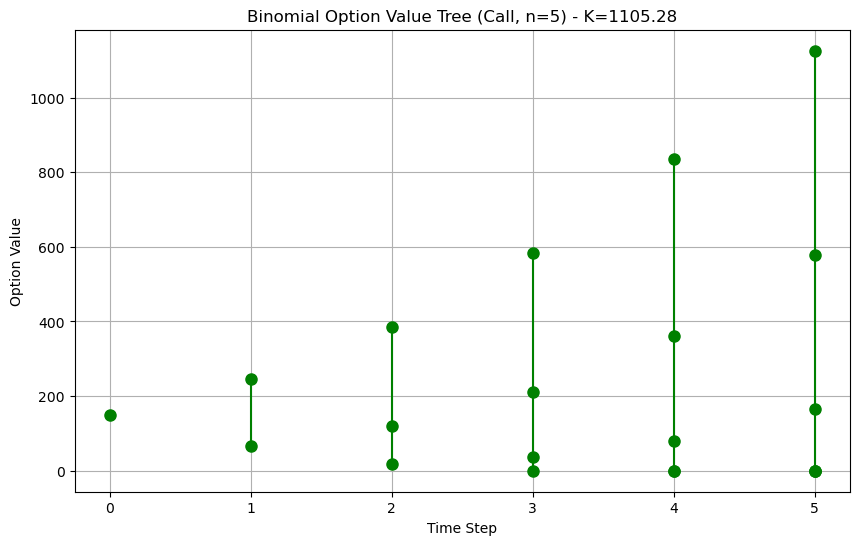

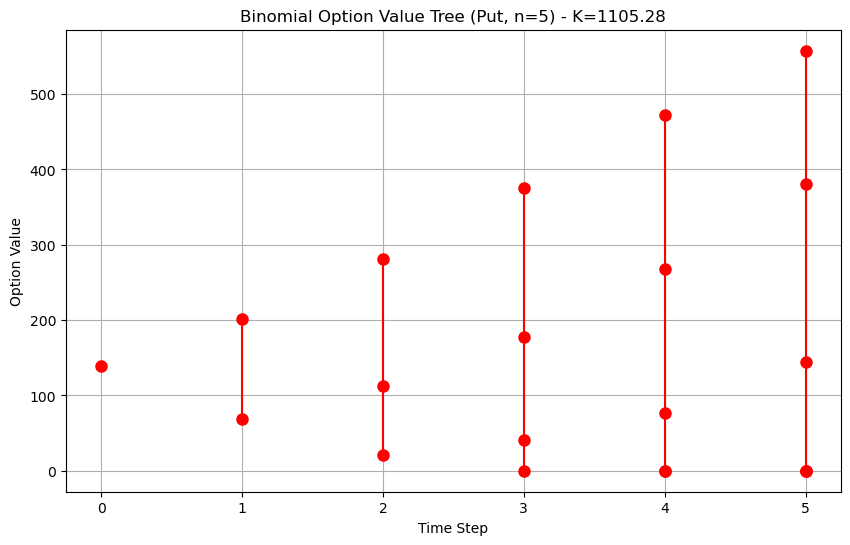

In [159]:
# Modified Binomial Tree Model (CRR Method) to return the option value tree
def binomial_tree_with_tree(S, K, T, r, sigma, n=100, option_type='call'):
    """Calculates European option price and returns the option value tree using the Binomial Tree (CRR) model."""
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize price tree
    prices = np.zeros((n + 1, n + 1))
    prices[0, 0] = S

    # Build price tree
    for i in range(1, n + 1):
        prices[i, 0] = prices[i - 1, 0] * d
        for j in range(1, i + 1):
            prices[i, j] = prices[i - 1, j - 1] * u

    # Initialize option value tree at expiration
    option_values = np.zeros((n + 1, n + 1))
    if option_type == 'call':
        option_values[n, :] = np.maximum(0, prices[n, :] - K)
    elif option_type == 'put':
        option_values[n, :] = np.maximum(0, K - prices[n, :])
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    # Backward induction to find option value tree
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_values[i, j] = np.exp(-r * dt) * (p * option_values[i + 1, j + 1] + (1 - p) * option_values[i + 1, j])

    return option_values, prices # Return the option value tree and the price tree (optional for plotting)

# Load data ('tr_eikon_eod_data.csv' in the same directory-one of the problem i encountered)
try:
    data = pd.read_csv('tr_eikon_eod_data.csv')
    S = data['AMZN.O'].iloc[-1]  # Current stock price
    K = S  # At-the-money strike price
    T = 1  # Time to maturity (1 year)
    r = 0.01  # Risk-free rate (1%)
    sigma = np.std(data['AMZN.O'].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility
    n = 5 # Reduce n for clearer visualization

    # Get the call option value tree
    call_option_values_tree, call_prices_tree = binomial_tree_with_tree(S, K, T, r, sigma, n=n, option_type='call')

    # Plotting the Call Option Value Tree
    plt.figure(figsize=(10, 6))
    plt.title(f'Binomial Option Value Tree (Call, n={n}) - K={K:.2f}')
    for i in range(n + 1):
        plt.plot(np.full(i + 1, i), call_option_values_tree[i, :i + 1], 'o-', color='green', markersize=8)
    plt.xlabel('Time Step')
    plt.ylabel('Option Value')
    plt.grid(True)
    plt.xticks(range(n + 1))
    plt.show()

    # Get the put option value tree
    put_option_values_tree, put_prices_tree = binomial_tree_with_tree(S, K, T, r, sigma, n=n, option_type='put')

    # Plotting the Put Option Value Tree
    plt.figure(figsize=(10, 6))
    plt.title(f'Binomial Option Value Tree (Put, n={n}) - K={K:.2f}')
    for i in range(n + 1):
        plt.plot(np.full(i + 1, i), put_option_values_tree[i, :i + 1], 'o-', color='red', markersize=8)
    plt.xlabel('Time Step')
    plt.ylabel('Option Value')
    plt.grid(True)
    plt.xticks(range(n + 1))
    plt.show()

except FileNotFoundError:
    print("Error: The file 'tr_eikon_eod_data.csv' was not found.")
except KeyError as e:
    print(f"Error: The column '{e}' was not found in the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Monte Carlo Call Price: 145.3879
Monte Carlo Put Price: 130.8148


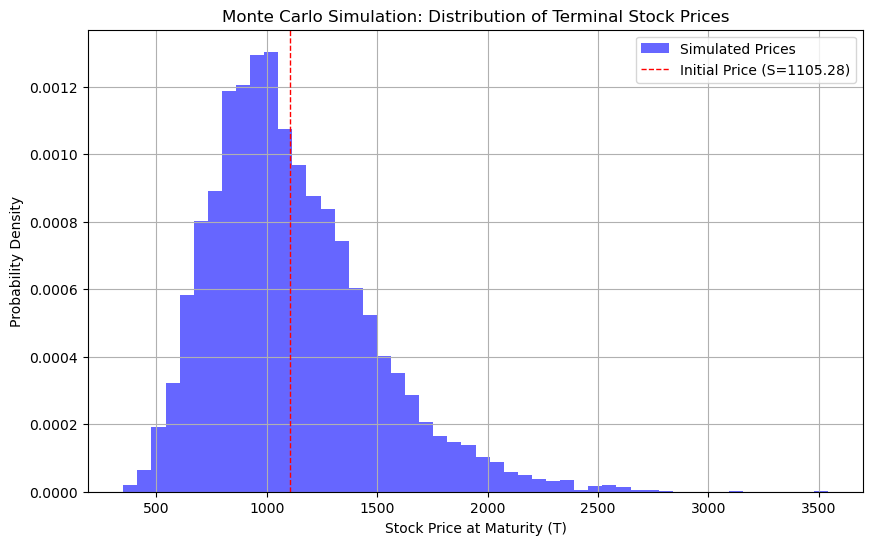

An unexpected error occurred: name 'call_price_mc' is not defined


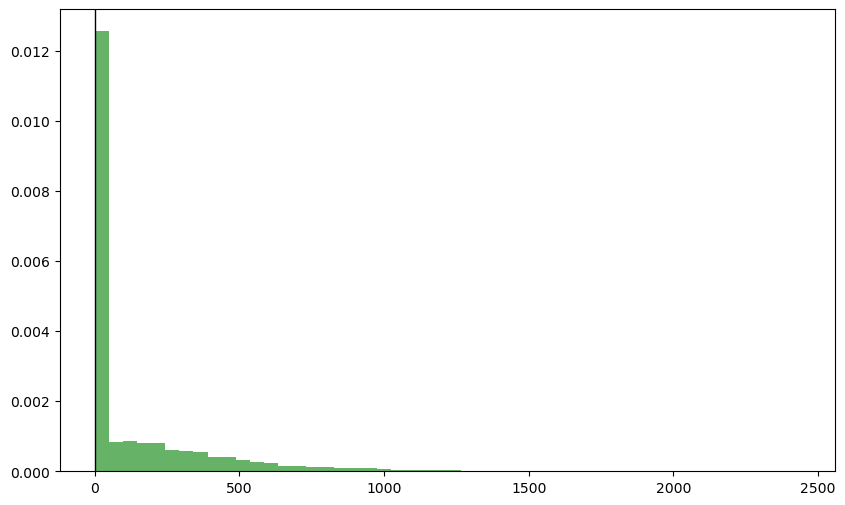

In [173]:

# 3. Monte Carlo Simulation

#Load data ('tr_eikon_eod_data.csv' in the same directory-one of the problem i encountered)

def monte_carlo_option_price(S, K, T, r, sigma, n_sim=10000, option_type='call'):
    """Calculates European option price using Monte Carlo simulation."""
    dt = T
    Z = np.random.standard_normal(n_sim)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    if option_type == 'call':
        payoffs = np.maximum(0, ST - K)
    elif option_type == 'put':
        payoffs = np.maximum(0, K - ST)
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    price = np.exp(-r * T) * np.mean(payoffs)
    return price, ST

try:
    data = pd.read_csv('tr_eikon_eod_data.csv')
    S = data['AMZN.O'].iloc[-1]  # Current stock price
    K = S  # At-the-money strike price
    T = 1  # Time to maturity (1 year)
    r = 0.01  # Risk-free rate (1%)
    sigma = np.std(data['AMZN.O'].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility
    n_sim = 10000

    call_prices_mc, call_terminal_prices  = monte_carlo_option_price(S, K, T, r, sigma, n_sim=5000, option_type='call')
    put_prices_mc, put_terminal_prices  = monte_carlo_option_price(S, K, T, r, sigma, n_sim=5000, option_type='put')

    print(f"Monte Carlo Call Price: {call_prices_mc:.4f}")
    print(f"Monte Carlo Put Price: {put_prices_mc:.4f}")

    # Visualization of Monte Carlo Simulation Results

    # 1. Histogram of Simulated Terminal Stock Prices
    plt.figure(figsize=(10, 6))
    plt.hist(call_terminal_prices, bins=50, density=True, alpha=0.6, color='blue', label='Simulated Prices')
    plt.axvline(S, color='red', linestyle='dashed', linewidth=1, label=f'Initial Price (S={S:.2f})')
    plt.title('Monte Carlo Simulation: Distribution of Terminal Stock Prices')
    plt.xlabel('Stock Price at Maturity (T)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Payoff Distribution for Call Option
    call_payoffs = np.maximum(0, call_terminal_prices - K)
    plt.figure(figsize=(10, 6))
    plt.hist(call_payoffs, bins=50, density=True, alpha=0.6, color='green', label='Call Payoffs')
    plt.axvline(0, color='black', linestyle='-', linewidth=1, label='Payoff Threshold')
    plt.axvline(call_price_mc, color='red', linestyle='dashed', linewidth=1, label=f'Estimated Call Price={call_price_mc:.2f}')
    plt.title('Monte Carlo Simulation: Distribution of Call Option Payoffs')
    plt.xlabel('Call Option Payoff at Maturity')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Payoff Distribution for Put Option
    put_payoffs = np.maximum(0, K - put_terminal_prices)
    plt.figure(figsize=(10, 6))
    plt.hist(put_payoffs, bins=50, density=True, alpha=0.6, color='purple', label='Put Payoffs')
    plt.axvline(0, color='black', linestyle='-', linewidth=1, label='Payoff Threshold')
    plt.axvline(put_price_mc, color='red', linestyle='dashed', linewidth=1, label=f'Estimated Put Price={put_price_mc:.2f}')
    plt.title('Monte Carlo Simulation: Distribution of Put Option Payoffs')
    plt.xlabel('Put Option Payoff at Maturity')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print("Error: The file 'tr_eikon_eod_data.csv' was not found.")
except KeyError as e:
    print(f"Error: The column '{e}' was not found in the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Finite Difference Call Price: -2173436697575534554513949777874263710446081022904503111202200241058617245846656994741609755261747656875422279908659679619742966580858158160450035386411654193440211599360.0000
Finite Difference Put Price: -51198100645095759229678433347768282019226367859821414365885710110313897979657309666402607539282389853961764197093706198258881838860872974336.0000


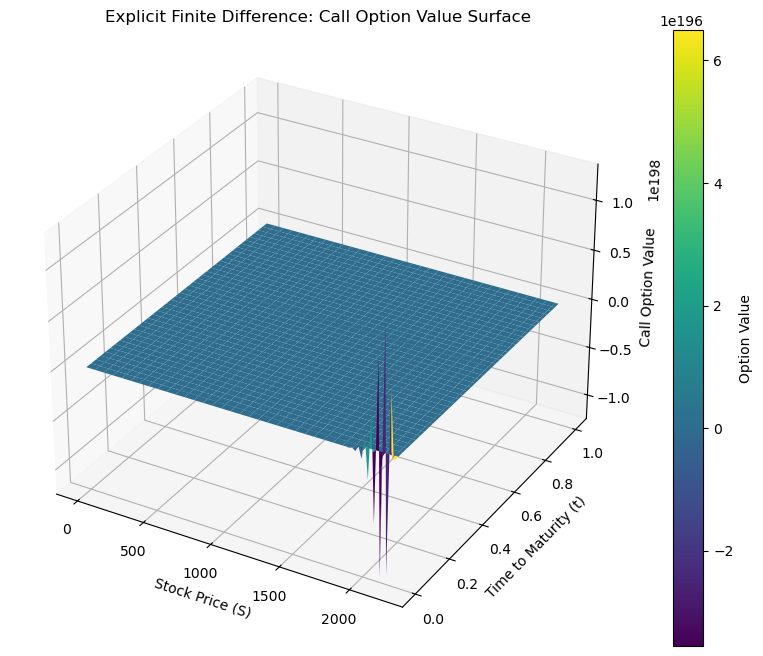

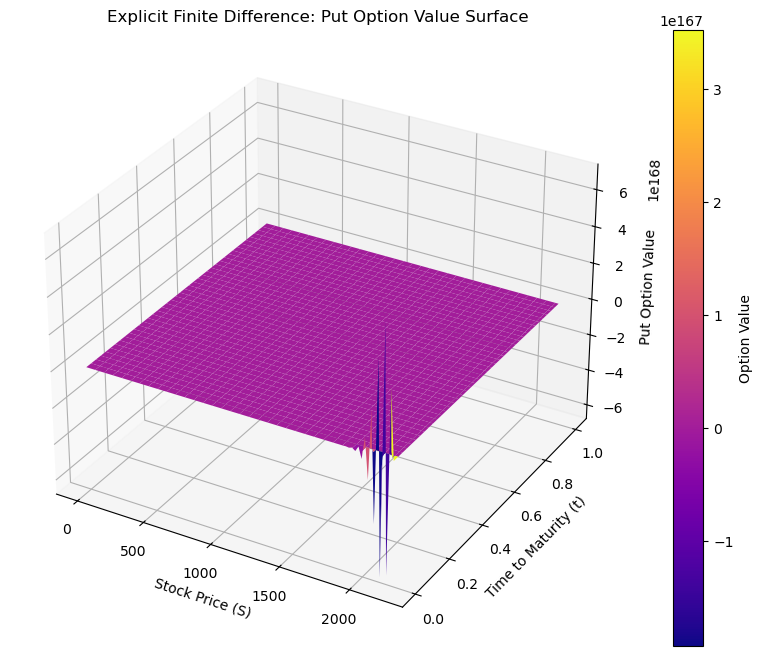

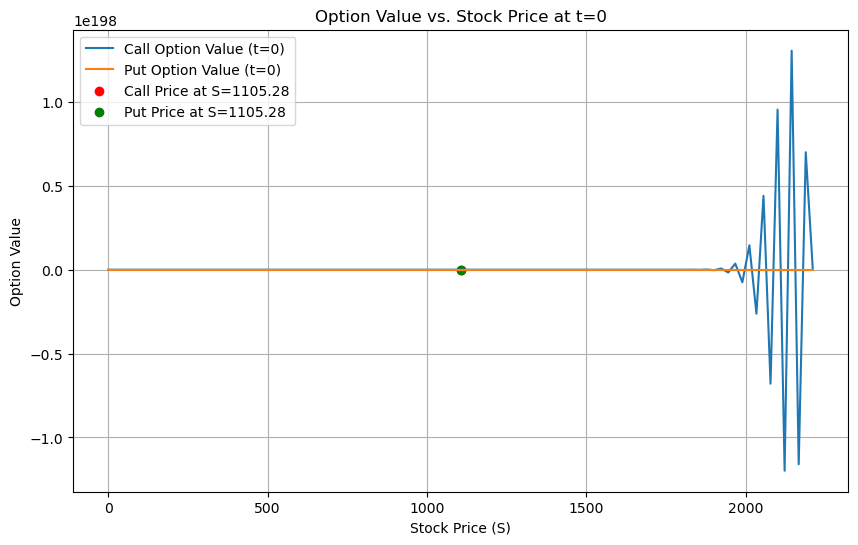

In [183]:
# 4. Finite Difference Method (Explicit)
def explicit_finite_difference(S, K, T, r, sigma, M=100, N=200, option_type='call'):
    """Calculates European option price using the explicit finite difference method and returns the grid."""
    S_max = 2 * K
    dS = S_max / M
    dt = T / N
    grid = np.zeros((M + 1, N + 1))
    S_values = np.linspace(0, S_max, M + 1)
    time_values = np.linspace(0, T, N + 1)  # Added time values

    # Boundary conditions at expiration
    if option_type == 'call':
        grid[:, N] = np.maximum(0, S_values - K)
    elif option_type == 'put':
        grid[:, N] = np.maximum(0, K - S_values)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    # Boundary conditions at S=0 and S=S_max
    if option_type == 'call':
        grid[0, :] = 0
        grid[M, :] = S_max * np.exp(-r * time_values) - K * np.exp(-r * time_values)
    elif option_type == 'put':
        grid[0, :] = K * np.exp(-r * time_values)
        grid[M, :] = 0

    # Explicit finite difference iteration
    for j in range(N - 1, -1, -1):
        for i in range(1, M):
            sigma2 = sigma ** 2
            delta = (sigma2 * i ** 2 * dS ** 2 * (grid[i + 1, j + 1] - 2 * grid[i, j + 1] + grid[i - 1, j + 1]) / (2 * dS ** 2) +
                     r * i * dS * (grid[i + 1, j + 1] - grid[i - 1, j + 1]) / (2 * dS) +
                     r * grid[i, j + 1]) * dt
            grid[i, j] = grid[i, j + 1] - delta

    # Interpolate to find the option price at the initial stock price
    price = np.interp(S[0], S_values, grid[:, 0])
    return price, S_values, grid, time_values # Return price, S_values, the grid, and time values

try:
    data = pd.read_csv('tr_eikon_eod_data.csv')
    S_initial = data['AMZN.O'].iloc[-1]  # Current stock price
    K = S_initial  # At-the-money strike price
    T = 1  # Time to maturity (1 year)
    r = 0.01  # Risk-free rate (1%)
    sigma = np.std(data['AMZN.O'].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility

    # Ensure S is a NumPy array for the function
    S_array = np.array([S_initial])

    # Calculate call and put prices and the option value grids
    call_price_fd, S_grid, call_option_grid, time_grid_call = explicit_finite_difference(S_array, K, T, r, sigma, option_type='call')
    put_price_fd, S_grid_put, put_option_grid, time_grid_put = explicit_finite_difference(S_array, K, T, r, sigma, option_type='put')

    print(f"Finite Difference Call Price: {call_price_fd:.4f}")
    print(f"Finite Difference Put Price: {put_price_fd:.4f}")

    # Visualization of Finite Difference Results

    # 1. Option Value Surface (Call)
    S_mesh, T_mesh = np.meshgrid(S_grid, time_grid_call)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(S_mesh, T_mesh, call_option_grid.T, cmap='viridis') # Transpose grid for correct plotting
    ax.set_xlabel('Stock Price (S)')
    ax.set_ylabel('Time to Maturity (t)')
    ax.set_zlabel('Call Option Value')
    ax.set_title('Explicit Finite Difference: Call Option Value Surface')
    fig.colorbar(surf, ax=ax, label='Option Value')
    plt.show()

    # 2. Option Value Surface (Put)
    S_mesh_put, T_mesh_put = np.meshgrid(S_grid_put, time_grid_put)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(S_mesh_put, T_mesh_put, put_option_grid.T, cmap='plasma') # Transpose grid for correct plotting
    ax.set_xlabel('Stock Price (S)')
    ax.set_ylabel('Time to Maturity (t)')
    ax.set_zlabel('Put Option Value')
    ax.set_title('Explicit Finite Difference: Put Option Value Surface')
    fig.colorbar(surf, ax=ax, label='Option Value')
    plt.show()

    # 3. Option Value vs. Stock Price at t=0 (Call and Put)
    plt.figure(figsize=(10, 6))
    plt.plot(S_grid, call_option_grid[:, 0], label='Call Option Value (t=0)')
    plt.plot(S_grid_put, put_option_grid[:, 0], label='Put Option Value (t=0)')
    plt.scatter(S_initial, call_price_fd, color='red', marker='o', label=f'Call Price at S={S_initial:.2f}')
    plt.scatter(S_initial, put_price_fd, color='green', marker='o', label=f'Put Price at S={S_initial:.2f}')
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Value')
    plt.title('Option Value vs. Stock Price at t=0')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print("Error: The file 'tr_eikon_eod_data.csv' was not found.")
except KeyError as e:
    print(f"Error: The column '{e}' was not found in the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    